# Clean the contents of the test and validation set to remove mis-labelled clips

## - Input a split database  on disk (e.g. valid split or test split)
## - Output a verified db split on disk. 

### General rules of thumb for all ML models
- The dataset needs to contain true examples of calls and absences.
This necessetates some cleaning of the human labels since some of them are mis-labelled. 
- The test set should represent the situation at inference as closely as possible, so that the measured metrics more closely match what is expected to be the case in the field. 
At inference time the audio will include a range of song volumes and clarity - all the way from focal and loud, to far away and masked and everything between.

### Considerations for this project
- The model needs to output a lower score for quieter calls - this is to enable density estimation and other downstream statistical applications. 
- To enable this, the __training__ set will contain focal samples, whilst the test set will contain a mixture of focal and distant samples. The assumption is that this will produce a model which outputs a lower score for quieter samples. 
 

### Cleaning samples from the test set introduces an interesting problem:
There's a subjective threshold in the decision of whether to throw a sample out of the test set or not. Initially the test set contains a random sample of the human labelled OSFL calls. These will contain audio which spread the full range of human detection ability, plus some errors. 


In cleaning out the errors, I'll come across some which look like errors but which I'm not sure about, because to some degree they are masked or quiet. Throwing these out could be removing some hard edge cases from the test set, which could be useful for measuring increases in recall.

 To ensure that the test set contains only accurate labels, I could throw out all the samples except those which I'm 100% convinced are correct. But in doing so I'd make a test set which by definition, contains easy to recognize samples. This would have a direct affect on the model metrics. 

At the other extreme, I could do nothing - leave some errors in the test set, which would have the advantage of being closer to some notion of ground truth - these are the labels which a range of human labellers returned, plus some errors which put an upper limit on how high the metric measurements can get. 
The clarity of the samples left in the test set will directly affect the performance metric of a model tested on this test set. 



# Proposed solution:
Rather than throw out items from the test set, I'll label them with confidence scores:
- 0 UNCHECKED means it hasn't been verified
- 1 DISCARD is something I should throw out, 
- 2 UNSURE is not sure , 
- 3 VERIFIED is definitely an olive sided flycatcher. 
- 4 FOCAL Optionally tag as focal OSFL
- 5 Label needs changing to OSFL 

0 - unchecked

1 - discard

2 - unable to tell

3 - correct label

4 - focal OSFL call

5 - absent tag needs changing to OSFL

This will let me measure performance on a test set which I know only contains verified labels, and optionally mix in on the hard to detect subset which might otherwise get thrown out.


# Label the test set with confidence scores
This part of the notebook 

- takes a test set saved to disk as an AudioFileDataset (or just a pandas dataframe)
- loads each sample with playback option
- takes a user typed label as input
- saves the label in a column of the dataframe titled 'confidence' 
- saves the dataset back to disk



In [29]:
from pathlib import Path
import pandas as pd
import sys
BASE_PATH = Path.cwd().parent.parent
sys.path.append(str(BASE_PATH))
import opensoundscape as opso
from opensoundscape import Audio, Spectrogram
from opensoundscape.preprocess.utils import show_tensor
import torch

# Load the validation AudioFileDataset df from disk

In [154]:
data_path = Path.cwd().parent.parent / "data"
df_valid: pd.DataFrame = pd.read_pickle(data_path / "interim" / "valid_set" / "valid_df_verified.pkl")
df_valid_with_preds = pd.read_pickle(data_path / "processed" / "osfl_model_predictions" / "validation_set_predictions_verified.pkl")

In [155]:
# add a column to the dataframe to store the confidence of the label, if it doesn't alredy exist
if 'confidence_cat' not in df_valid.columns:
    df_valid['confidence_cat'] = 0
idx = 0
confidence = 0 # 0 means unchecked. 

In [156]:
df_valid.sample()

,,,target_absence,target_presence,confidence_cat
file,start_time,end_time,,,
../../data/raw/recordings/OSFL/recording-330554.flac,12.0,15.0,1.0,0.0,0


In [157]:
df_valid_with_preds.sample()

,,,target_presence,confidence_cat,present_pred,loss
file,start_time,end_time,,,,
../../data/raw/recordings/OSFL/recording-293057.mp3,10.5,13.5,0.0,0,0.032774,0.032774


In [158]:
def verify_samples(df: pd.DataFrame, target=0.0, loss_sorted=False):
    # Filter the split dataset further into unverified and present tags.
    unverified = df[df['confidence_cat'] == 0]
    unverified_target_clips = unverified.loc[unverified['target_presence'] == target]
    if len(unverified_target_clips) == 0:
        print("No unverified clips within chosen target class.")
        return df
    
    if loss_sorted:
        # Sort the unverified clips by the loss value.
        unverified_target_clips = unverified_target_clips.sort_values(by='loss', ascending=False)

    # Set the confidence cat to 0 so that any skipped clips or crashes don't get saved as previous confidence.
    confidence = 0

    clip_idx = unverified_target_clips.index[0]
    path, offset, end_time = clip_idx
    duration = end_time - offset
    audio = Audio.from_file(path, offset=offset, duration=duration)
    spec = Spectrogram.from_audio(audio)
    print(f"target = {df.loc[clip_idx].target_presence}, prediction = {df.loc[clip_idx].present_pred} loss = {df.loc[clip_idx].loss}")
    audio.show_widget()
    spec.plot()
    user_confidence = input("enter confidence. 1=Discard, 2=Unsure, 3=Verified, 4=Focal, 5=Re-label-as-OSFL")

    # save the user input confidence back to the original dataframe.
    df.loc[clip_idx, 'confidence_cat'] = int(user_confidence)
    
    # display the counts
    print(f"added confidence tag {user_confidence} to the dataframe.")
    print(df.loc[df.target_presence == target].confidence_cat.value_counts())

    return df

# Run this line and pass in a dataframe to verify samples. 

target = 0.0, prediction = 0.9986785054206848 loss = 0.9986785054206848


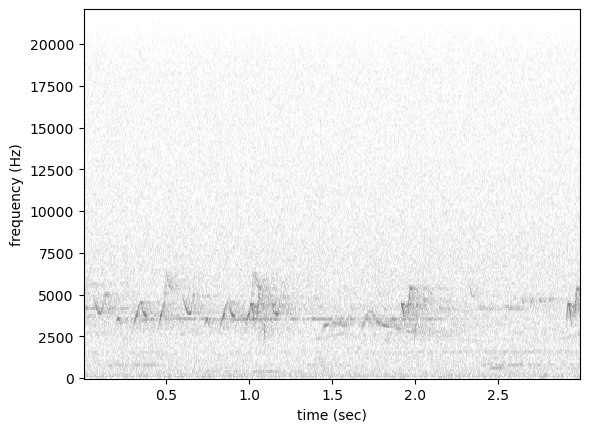

added confidence tag 0 to the dataframe.
confidence_cat
0    9909
5      19
3      11
2       8
Name: count, dtype: int64


/var/folders/hy/36n7jr6x3h74ddx507dc12_00000gn/T/ipykernel_52296/4112674990.py:28: PerformanceWarning: indexing past lexsort depth may impact performance.
  df.loc[clip_idx, 'confidence_cat'] = int(user_confidence)


In [159]:
df_valid_with_preds = verify_samples(df_valid_with_preds, loss_sorted=True)

In [160]:
df_valid.loc[df_valid.target_presence == 1.0]

target_absence  \
file                                               start_time end_time                   
../../data/raw/recordings/OSFL/recording-4478.mp3  30.0       33.0                 0.0   
                                                   66.0       69.0                 0.0   
                                                   121.5      124.5                0.0   
../../data/raw/recordings/OSFL/recording-4504.flac 57.0       60.0                 0.0   
                                                   58.5       61.5                 0.0   
...                                                                                ...   
../../data/raw/recordings/OSFL/recording-768530... 126.0      129.0                0.0   
../../data/raw/recordings/OSFL/recording-813302... 1.5        4.5                  0.0   
../../data/raw/recordings/OSFL/recording-816751... 1.5        4.5                  0.0   
                                                   3.0        6.0                  0.0   
../../data/raw/recordings/OSFL/recording-816752... 40.5       43.5                 0.0   

                                                                        target_presence  \
file                                               start_time end_time                    
../../data/raw/recordings/OSFL/recording-4478.mp3  30.0       33.0                  1.0   
                                                   66.0       69.0                  1.0   
                                                   121.5      124.5                 1.0   
../../data/raw/recordings/OSFL/recording-4504.flac 57.0       60.0                  1.0   
                                                   58.5       61.5                  1.0   
...                                                                                 ...   
../../data/raw/recordings/OSFL/recording-768530... 126.0      129.0                 1.0   
../../data/raw/recordings/OSFL/recording-813302... 1.5        4.5                   1.0   
../../data/raw/recordings/OSFL/recording-816751... 1.5        4.5                   1.0   
                                                   3.0        6.0                   1.0   
../../data/raw/recordings/OSFL/recording-816752... 40.5       43.5                  1.0   

                                                                        confidence_cat  
file                                               start_time end_time                  
../../data/raw/recordings/OSFL/recording-4478.mp3  30.0       33.0                   2  
                                                   66.0       69.0                   1  
                                                   121.5      124.5                  2  
../../data/raw/recordings/OSFL/recording-4504.flac 57.0       60.0                   3  
                                                   58.5       61.5                   3  
...                                                                                ...  
../../data/raw/recordings/OSFL/recording-768530... 126.0      129.0                  2  
../../data/raw/recordings/OSFL/recording-813302... 1.5        4.5                    3  
../../data/raw/recordings/OSFL/recording-816751... 1.5        4.5                    2  
                                                   3.0        6.0                    1  
../../data/raw/recordings/OSFL/recording-816752... 40.5       43.5                   2  

[1043 rows x 3 columns]

# Save the validation work

In [1108]:
df_valid.to_pickle(data_path / "interim" / "valid_set" / "valid_df_verified.pkl")

In [161]:
df_valid_with_preds_verified = df_valid_with_preds
df_valid_with_preds_verified.to_pickle(data_path / "processed" / "osfl_model_predictions" / "validation_set_predictions_verified.pkl")

In [163]:
df_valid_with_preds_verified

target_presence  \
file                                               start_time end_time                    
../../data/raw/recordings/OSFL/recording-4478.mp3  0.0        3.0                   0.0   
                                                   1.5        4.5                   0.0   
                                                   3.0        6.0                   0.0   
                                                   4.5        7.5                   0.0   
                                                   6.0        9.0                   0.0   
...                                                                                 ...   
../../data/raw/recordings/OSFL/recording-816752... 33.0       36.0                  0.0   
                                                   34.5       37.5                  0.0   
                                                   36.0       39.0                  0.0   
                                                   37.5       40.5                  0.0   
                                                   40.5       43.5                  1.0   

                                                                        confidence_cat  \
file                                               start_time end_time                   
../../data/raw/recordings/OSFL/recording-4478.mp3  0.0        3.0                    3   
                                                   1.5        4.5                    3   
                                                   3.0        6.0                    3   
                                                   4.5        7.5                    3   
                                                   6.0        9.0                    3   
...                                                                                ...   
../../data/raw/recordings/OSFL/recording-816752... 33.0       36.0                   0   
                                                   34.5       37.5                   0   
                                                   36.0       39.0                   0   
                                                   37.5       40.5                   0   
                                                   40.5       43.5                   2   

                                                                        present_pred  \
file                                               start_time end_time                 
../../data/raw/recordings/OSFL/recording-4478.mp3  0.0        3.0           0.938833   
                                                   1.5        4.5           0.381346   
                                                   3.0        6.0           0.628573   
                                                   4.5        7.5           0.774142   
                                                   6.0        9.0           0.654895   
...                                                                              ...   
../../data/raw/recordings/OSFL/recording-816752... 33.0       36.0          0.094164   
                                                   34.5       37.5          0.046067   
                                                   36.0       39.0          0.128044   
                                                   37.5       40.5          0.318316   
                                                   40.5       43.5          0.994107   

                                                                            loss  
file                                               start_time end_time            
../../data/raw/recordings/OSFL/recording-4478.mp3  0.0        3.0       0.938833  
                                                   1.5        4.5       0.381346  
                                                   3.0        6.0       0.628573  
                                                   4.5        7.5       0.774142  
                                                   6.0        9.0       0.